In [13]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt 
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import alphalens as al
import warnings
import json

from functions.datareader import pull_stock_data, YFinanceReader
from functions.portfolio_optimizer import RiskModelPCA, OptimalHoldings, OptimalHoldingsStrictFactor
from functions.alpha_factor_evaluator import AlphaFactorEvaluator
from functions.indicators import TechnicalIndicators

warnings.filterwarnings('ignore')

In [14]:
# define all parameters
START_DATE = dt.date(2015, 1, 1)

<h1 style="color:turquoise">Load data from local</h1>

In [15]:
# sectors
with open('./keys/set_sectors.json') as f:
    sectors = json.load(f)

In [16]:
# price data
raw_df = pd.read_parquet('./data/set')

raw_df.set_index(pd.DatetimeIndex(raw_df.index))
raw_df.index.name = 'date'
raw_df.tail(2)

,ticker,close,dividends,high,low,open,stock splits,volume
date,,,,,,,,
2023-04-05,WHA,4.38,0.0,4.48,4.36,4.38,0.0,108015000.0
2023-04-07,WHA,4.38,0.0,4.38,4.32,4.36,0.0,43875200.0


In [17]:
# map sector using the sector dict above
vk = [(k, v) for k, v in sectors.items()]
sector_mapper = {sub: s[0]for s in vk for sub in s[1]}
raw_df['sector'] = raw_df['ticker'].map(sector_mapper)

In [18]:
# filter only stocks that exist since our start date
first_date_df = raw_df[['ticker']].reset_index().groupby('ticker').min()
first_date_df['is_available_since_start'] = first_date_df['date'].apply(lambda x: True if x <= START_DATE else False)

available_tickers = first_date_df[first_date_df['is_available_since_start'] == True].reset_index()['ticker']

# create a sector_mapper of available stocks
sector_mapper_available = {s:sector_mapper[s] for s in sector_mapper if s in available_tickers.values}

# filter only selected stocks
df = raw_df.reset_index().merge(available_tickers, left_on = 'ticker', right_on = 'ticker').set_index('date')

# create an OHLCV df in order to calculate technical indicators
ohlcv_df = df[['ticker', 'open', 'high', 'low', 'close', 'volume']]

# create a dataframe of close price
close_df = df[['ticker', 'sector', 'close']]

<h1 style="color:turquoise">Prepare data</h1>

<h3>Technical Indicators</h3>

In [19]:
ti_df = pd.DataFrame()

# * split multi-index dataframe to a dict of which each value represents OHLCV of each stock
for ticker in available_tickers.values:
    ticker_df = ohlcv_df[ohlcv_df['ticker'] == ticker].drop('ticker', axis = 1)
    
    ti = TechnicalIndicators(ticker_df)
    res_dict = dict()
    res_dict['rsi'] = ti.RSI(n = 14)
    res_dict['stochastic_rsi_k'], res_dict['stochastic_rsi_d'] = ti.stochasticRSI(n = 14, k = 3, d = 3)
    res_dict['macd'], res_dict['macd_signal'] = ti.MACD(n_long = 26, n_short = 12)
    res_dict['vol_change_pct'] = ti.volume_change_pct()
    res_dict['overnight_return'] = ti.overnight_return()
    res_dict['cdvr'] = ti.candlestick_volume_ratio()
    res_dict['bollinger_ratio'] = ti.bollinger_ratio(n = 20, k = 2)
    res_df = pd.DataFrame.from_dict(res_dict).reset_index()
    res_df.insert(1, 'ticker', ticker)

    ti_df = ti_df.append(res_df, ignore_index = True)

# * filter date
ti_df = ti_df[ti_df['date'].dt.date >= START_DATE] \
            .set_index(['date', 'ticker'])


In [20]:
ti_df.head()

,,rsi,stochastic_rsi_k,stochastic_rsi_d,macd,macd_signal,vol_change_pct,overnight_return,cdvr,bollinger_ratio
date,ticker,,,,,,,,,
2015-01-05,AEONTS,35.714143,0.075354,0.025118,-0.061802,0.593707,1.618357,-9.216493e-03,0.000007,0.110594
2015-01-06,AEONTS,33.333215,0.023445,0.032933,-0.182336,0.438499,0.568266,-9.259356e-03,0.000014,0.166328
2015-01-07,AEONTS,24.999799,0.000000,0.032933,-0.243076,0.302184,-0.364706,4.608375e-03,0.000015,0.224731
2015-01-08,AEONTS,33.333093,0.156861,0.060102,-0.224660,0.196815,-0.183333,-1.043537e-07,0.000045,0.331305
2015-01-09,AEONTS,33.333093,0.156861,0.104574,-0.207671,0.115918,1.607710,-9.090909e-03,0.000014,0.346129


<h3>Daily Return</h3>

In [21]:
daily_return_df = close_df.pivot(columns = 'ticker', values = 'close').pct_change().shift(1).mul(100)

# * filter date
daily_return_df = daily_return_df[daily_return_df.index.date >= START_DATE]

# * melt processed dataframe
daily_return_df = pd.melt(daily_return_df.reset_index(), id_vars='date', value_name='return', var_name='ticker')
daily_return_df.set_index(['date', 'ticker'], inplace=True)

In [22]:
# TODO: combine x and y
df = ti_df.merge(daily_return_df, left_index=True, right_index=True)

# * map sector
sector_inversed = {v:k for k in sectors for v in sectors[k]}
df['sector'] = df.index.get_level_values(1).map(sector_inversed)

In [23]:
# df.head()

<h2>One-Hot Encode Sector</h2>

In [32]:
import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from autosklearn.regression import AutoSKlearnRegressor

In [27]:
ohe = OneHotEncoder()
ohe.fit(df[['sector']])
sector_dummy = pd.DataFrame(ohe.transform(df[['sector']]).toarray(), columns = ohe.get_feature_names_out(), index = df.index)

In [28]:
df = df.merge(sector_dummy, left_index=True, right_index=True).drop('sector', axis = 1)

In [29]:
# TODO: split data
TRAIN_SIZE = 0.7
VALIDATE_SIZE = 0.2

dates = sorted(df.index.get_level_values(0))
n_data = len(dates)
train_split = int(TRAIN_SIZE * n_data)
val_split = int(VALIDATE_SIZE * n_data)

train_dates = dates[:train_split]
val_dates = dates[train_split:train_split + val_split]
test_dates = dates[train_split + val_split:]

x_train = df[df.index.isin(train_dates, level=0)]
x_val = df[df.index.isin(val_dates, level=0)]
x_test = df[df.index.isin(test_dates, level=0)]

y_train = x_train.pop('return')
y_val = x_val.pop('return')
y_test = x_test.pop('return')

In [33]:
def train_lgbm_regression_model(x_train, y_train, x_val, y_val, hyperparams):
    """
    Trains a LightGBM model for a regression problem using the given training and validation data, and multiple sets of hyperparameters.
    Selects the best set of hyperparameters based on the lowest MSE on the validation set.
    
    :param x_train: Training data features.
    :param y_train: Training data labels.
    :param x_val: Validation data features.
    :param y_val: Validation data labels.
    :param hyperparams: List of dictionaries, where each dictionary contains a set of hyperparameters for LightGBM.
    
    :return: Trained LightGBM model with the best set of hyperparameters.
    """
    best_mse = float('inf')
    best_model = None

    for params in hyperparams:
        # Define the LightGBM dataset
        train_data = lgb.Dataset(x_train, label=y_train)
        val_data = lgb.Dataset(x_val, label=y_val)

        # Train the LightGBM model
        model = lgb.train(
            params=params,
            train_set=train_data,
            valid_sets=[train_data, val_data],
            num_boost_round=1000,
            early_stopping_rounds=50,
            verbose_eval=100
        )

        # Get the predictions on the validation set
        y_pred = model.predict(x_val)

        # Compute the MSE on the validation set
        mse = mean_squared_error(y_val, y_pred)

        # Update the best model if the current model has a lower MSE
        if mse < best_mse:
            best_mse = mse
            best_model = model

    return best_model


In [38]:
# Define the sets of hyperparameters to test
hyperparams = [
    {'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 31},
    {'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 120},
    {'learning_rate': 0.01, 'max_depth': 5, 'num_leaves': 25}
]

model = train_lgbm_regression_model(x_train, y_train, x_val, y_val, hyperparams)

# Get the predictions on the test set
y_pred = model.predict(x_test)

# Compute the MSE on the test set
mse = mean_squared_error(y_test, y_pred)

print(f"Test MSE: {mse}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2321
[LightGBM] [Info] Number of data points in the train set: 76032, number of used features: 22
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.032999
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

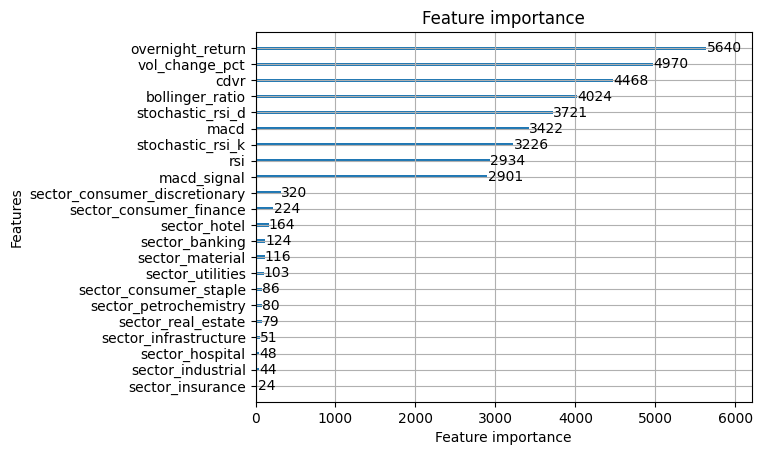

In [41]:
lgb.plot_importance(model)